In [26]:
%load_ext autoreload
%autoreload 2

from cluster_g_logit_init_acceptpsi_flatlam_healthtoo import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Dropbox (Personal)/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_91758/1184199116.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


In [28]:

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, n_samples=10000,seed=1)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data


Original shapes: Y=torch.Size([407878, 348, 52]), E=torch.Size([407878, 348]), G=torch.Size([407878, 36])
New shapes: Y=torch.Size([10000, 348, 52]), E=torch.Size([10000, 348]), G=torch.Size([10000, 36])


In [29]:
# When initializing the model:
original_G = G_100k # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')

original_cluster_sizes = {}
unique, counts = np.unique(initial_clusters, return_counts=True)
for k, count in zip(unique, counts):
    original_cluster_sizes[k] = count
print("\nOriginal cluster sizes:")
for k, count in original_cluster_sizes.items():
    print(f"Cluster {k}: {count} diseases")


Original cluster sizes:
Cluster 0: 16 diseases
Cluster 1: 21 diseases
Cluster 2: 15 diseases
Cluster 3: 82 diseases
Cluster 4: 5 diseases
Cluster 5: 7 diseases
Cluster 6: 8 diseases
Cluster 7: 22 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 8 diseases
Cluster 12: 7 diseases
Cluster 13: 13 diseases
Cluster 14: 10 diseases
Cluster 15: 5 diseases
Cluster 16: 29 diseases
Cluster 17: 17 diseases
Cluster 18: 9 diseases
Cluster 19: 23 diseases


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_91758/1949801412.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('initial_psi_400k.pt

In [30]:
print("Initial psi stats:")
print(f"Shape: {initial_psi.shape}")
print(f"Range: [{initial_psi.min():.2f}, {initial_psi.max():.2f}]")
print(f"Number of positive values: {(initial_psi > 0).sum().item()}")



Initial psi stats:
Shape: torch.Size([20, 348])
Range: [-2.04, 1.33]
Number of positive values: 348


In [44]:
# Load references (signatures only, no healthy)

# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=3,
    flat_lambda=True,
    init_var_scaler=1,
    prevalence_t=essentials['prevalence_t'],
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(4)
np.random.seed(4)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_91758/1001057424.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('initial_psi_400k.pt

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 6 diseases
Cluster 2: 13 diseases
Cluster 3: 97 diseases
Cluster 4: 22 diseases
Cluster 5: 22 diseases
Cluster 6: 15 diseases
Cluster 7: 17 diseases
Cluster 8: 35 diseases
Cluster 9: 6 diseases
Cluster 10: 13 diseases
Cluster 11: 9 diseases
Cluster 12: 11 diseases
Cluster 13: 6 diseases
Cluster 14: 17 diseases
Cluster 15: 5 diseases
Cluster 16: 15 diseases
Cluster 17: 8 diseases
Cluster 18: 17 diseases
Cluster 19: 3 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 11
Base value (first 5): tensor([-18.4207, -17.1035, -15.7863, -18.4207, -18.4207])
Base value centered (first 5): tensor([-0.3847,  0.9324,  2.2496, -0.3847, -0.3847])
Base value centered mean: 4.0349959817831405e-07
Gamma init for k=0 (first 5): tensor([ 0.0017,  0.0129, -0.0278, -0.0078,  0.0008])

Calculating gamma for k=1:
Number of diseases in cluster: 6
Base value (fi

In [45]:
model.genetic_scale

3

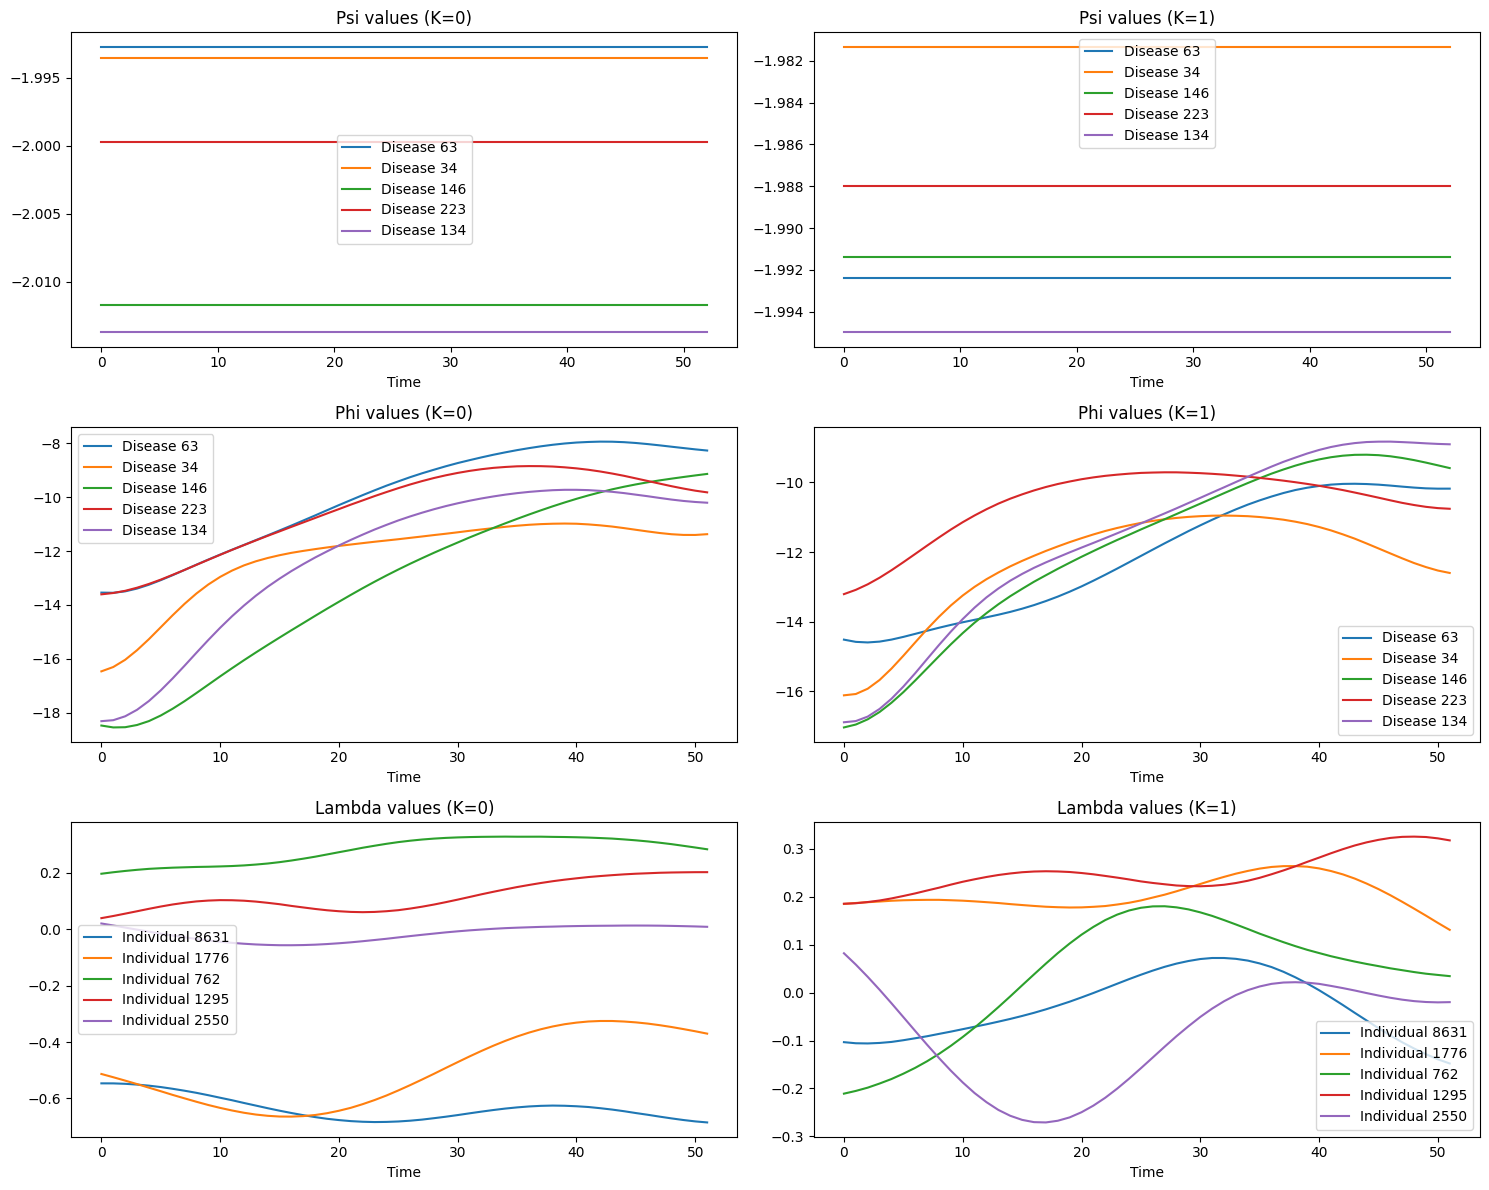


Cluster membership for sampled diseases:
Disease 63: Cluster 16
Disease 34: Cluster 3
Disease 146: Cluster 16
Disease 223: Cluster 3
Disease 134: Cluster 11

Cluster Assignments:

Cluster 0:
  - Rheumatic disease of the heart valves (prevalence: 0.0002)
  - Mitral valve disease (prevalence: 0.0003)
  - Aortic valve disease (prevalence: 0.0001)
  - Disease of tricuspid valve (prevalence: 0.0003)
  - Other forms of chronic heart disease (prevalence: 0.0004)
  - Cardiomegaly (prevalence: 0.0005)
  - Pericarditis (prevalence: 0.0001)
  - Primary/intrinsic cardiomyopathies (prevalence: 0.0001)
  - Left bundle branch block (prevalence: 0.0003)
  - Paroxysmal supraventricular tachycardia (prevalence: 0.0002)
  - Paroxysmal ventricular tachycardia (prevalence: 0.0001)
  - Atrial fibrillation and flutter (prevalence: 0.0009)
  - Congestive heart failure (CHF) NOS (prevalence: 0.0003)
  - Heart failure NOS (prevalence: 0.0007)
  - Pleurisy; pleural effusion (prevalence: 0.0008)
  - Congenital a

In [46]:
model.plot_initial_params()
# Convert disease names to list if it's not already
disease_names_list = list(essentials['disease_names'])

# Now visualize clusters
model.visualize_clusters(disease_names=disease_names_list)

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi_flatlam_healthtoo.py:835: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


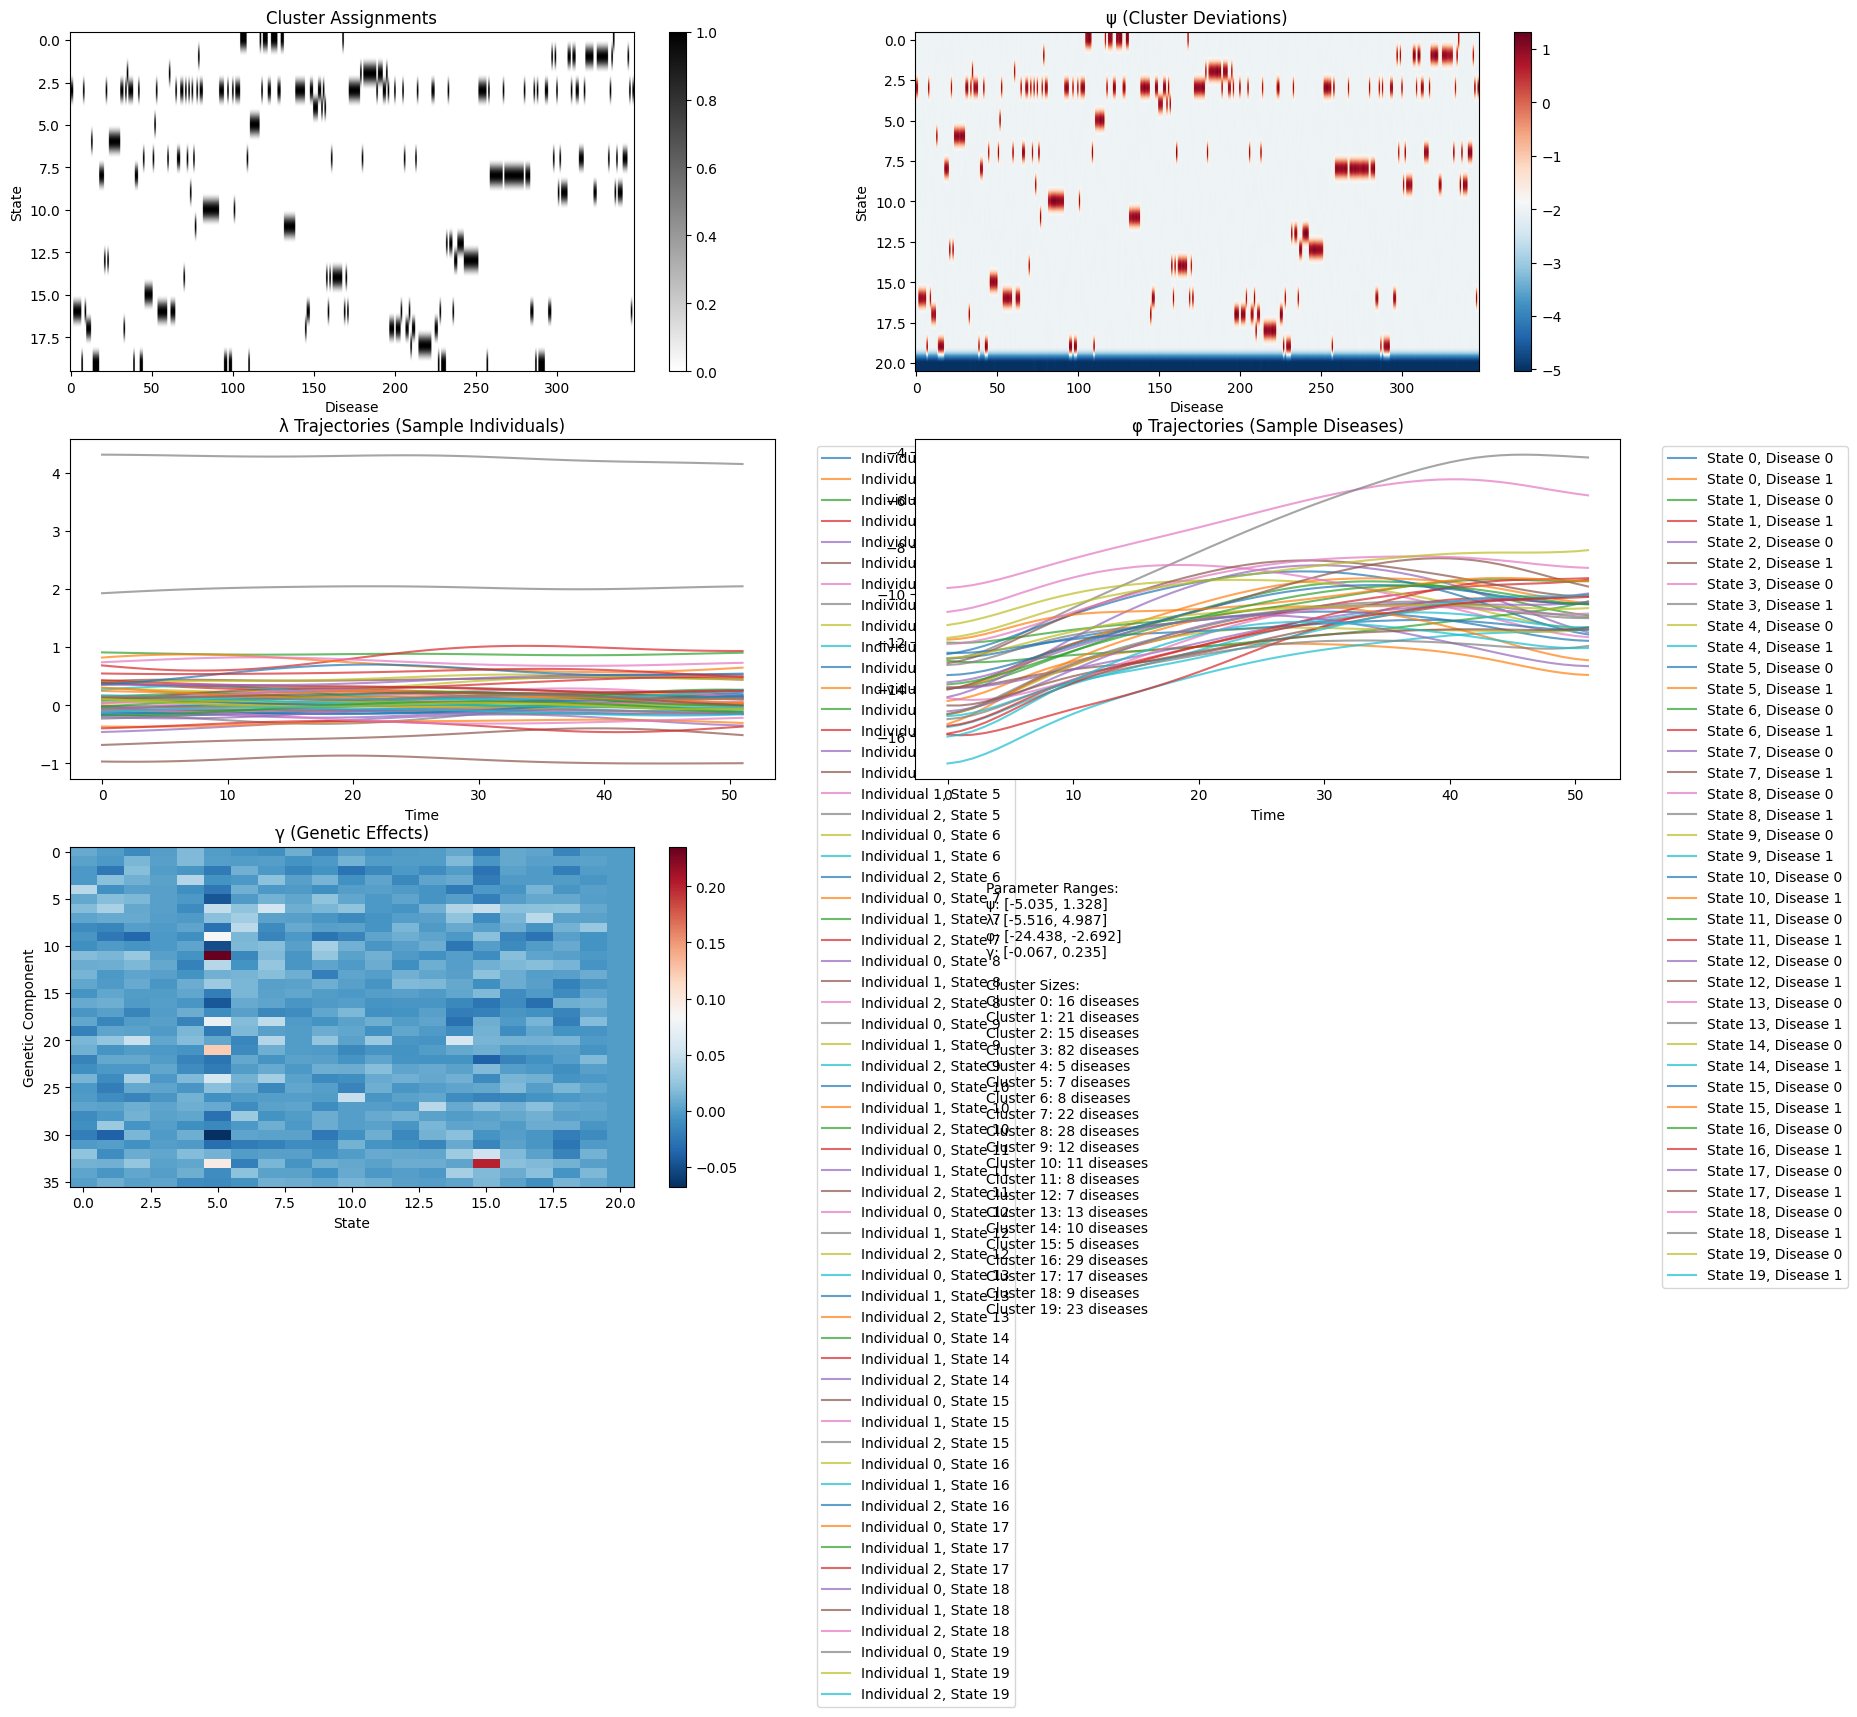

In [47]:
model.visualize_initialization()

In [48]:
initial_gamma = model.gamma.detach().clone()
initial_phi = model.phi.detach().clone()
initial_lambda = model.lambda_.detach().clone()
initial_psi = model.psi.detach().clone()


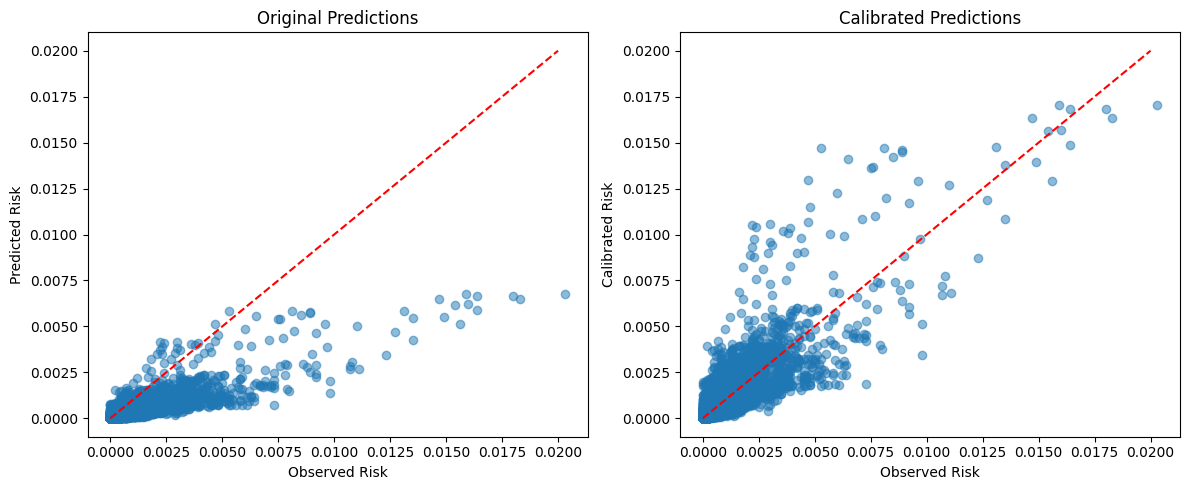

Mean observed risk: 0.000439
Mean predicted risk (original): 0.000174
Mean predicted risk (calibrated): 0.000439
Calibration scale factor: 2.524


In [49]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()

# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [50]:
ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

R^2: 0.682


In [51]:

history_new = model.fit(E_100k, num_epochs=100, learning_rate=1e-4, lambda_reg=1e-2)
        

Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi_flatlam_healthtoo.py:226: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 0
Loss: 615.3866
Psi gradient stats:
Mean: 4.4921e-06
Std:  4.6527e-03
Max:  1.6967e-02
Min:  -1.7764e-02
Epoch 0, Loss: 615.3866, Gradients - Lambda: 5.509e-02, Phi: 1.465e+01, Gamma: 1.805e-02, Psi: 1.776e-02
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 1
Loss: 614.4683
Psi gradient stats:
Mean: 4.4899e-06
Std:  4.6527e-03
Max:  1.6965e-02
Min:  -1.7766e-02
Epoch 1, Loss: 614.4683, Gradients - Lambda: 5.478e-02, Phi: 1.464e+01, Gamma: 1.802e-02, Psi: 1.777e-02

Estimated total training time: 47.4 minutes
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 2
Loss: 604.9035
Psi gradient stats:
Mean: 4.4144e-06
Std:  4.6518e-03
Max:  1.6952e-02
Min:  -1.7757e-02
Epoch 2, Loss: 604.9035, Gradients - Lambda: 5.120e-02, Phi: 1.459e+01, Gamma: 1.764e-02, Psi:

In [52]:
final_lambda = model.lambda_.detach().clone()
diff = torch.abs(final_lambda - initial_lambda)

print(f"Lambda changes with lr=1e-4:")
print(f"Mean absolute change: {torch.mean(diff):.3e}")
print(f"Max absolute change: {torch.max(diff):.3e}")
print(f"Std of changes: {torch.std(diff):.3e}")

Lambda changes with lr=1e-4:
Mean absolute change: 1.785e-04
Max absolute change: 4.760e-03
Std of changes: 1.793e-04


In [ ]:
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")

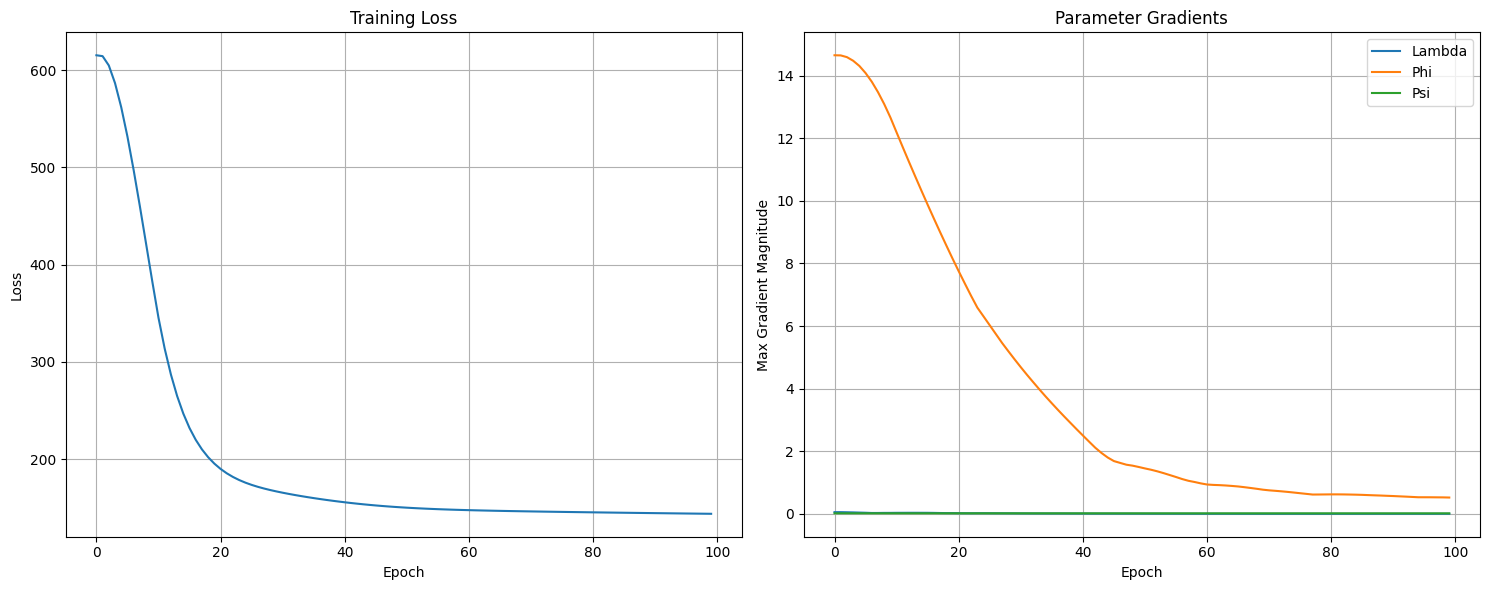

In [53]:

import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss
ax1.plot(history_new['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot gradients
ax2.plot(history_new['max_grad_lambda'], label='Lambda')
ax2.plot(history_new['max_grad_phi'], label='Phi')
ax2.plot(history_new['max_grad_psi'], label='Psi')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Max Gradient Magnitude')
ax2.set_title('Parameter Gradients')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [57]:
model_save_path='/Users/sarahurbut/Dropbox (Personal)/model_with_flathealthtrajectory_lr1e-3.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'clusters': model.clusters,
    'initial_phi': initial_phi, 
    'initial_lambda': initial_lambda, 
    'psi': model.psi,
    'Y': Y_100k,
    'prevalence_t': essentials['prevalence_t'],
    'logit_prevalence_t': model.logit_prev_t,
    'G': G_100k,
    'E': E_100k,
    'indices': indices,
    'disease_names': essentials['disease_names'],
    'hyperparameters': {
        'N': Y_100k.shape[0],
        'D': Y_100k.shape[1],
        'T': Y_100k.shape[2],
        'P': G_100k.shape[1],
        'K': model.phi.shape[0]
    }
}, model_save_path)



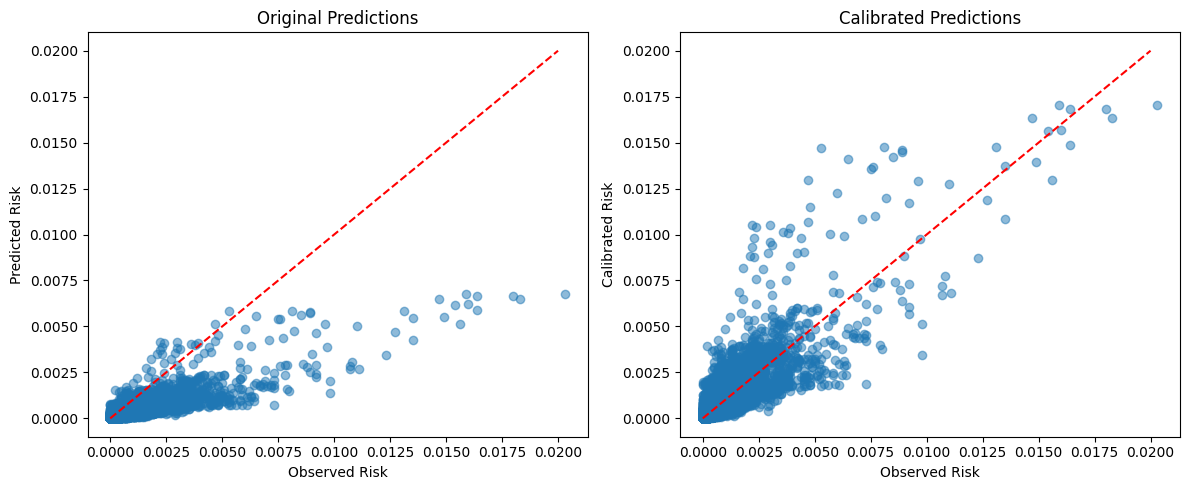

Mean observed risk: 0.000439
Mean predicted risk (original): 0.000174
Mean predicted risk (calibrated): 0.000439
Calibration scale factor: 2.524


In [58]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()

# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [59]:

ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

R^2: 0.682


In [60]:
def plot_signature_top_diseases_centered(model, disease_names, n_top=10):
    """
    Show top diseases for each signature, centered relative to prevalence
    """
    # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # For each signature, get top diseases
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        print(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):")
        for idx in top_indices:
            avg_effect = scores[idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            # Convert to odds ratio for interpretability
            odds_ratio = np.exp(avg_effect)
            print(f"{disease_names[idx]}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}")

# Run visualization
plot_signature_top_diseases_centered(model, essentials['disease_names'])


Top 10 diseases in Signature 0 (relative to baseline):
Pleurisy; pleural effusion: effect=2.366 (OR=10.66), std=0.199
Paroxysmal supraventricular tachycardia: effect=1.859 (OR=6.41), std=0.411
Paroxysmal ventricular tachycardia: effect=1.600 (OR=4.95), std=0.703
Congenital anomalies of great vessels: effect=1.468 (OR=4.34), std=1.052
Primary/intrinsic cardiomyopathies: effect=1.387 (OR=4.00), std=0.481
Other peripheral nerve disorders: effect=1.190 (OR=3.29), std=0.460
Atrial fibrillation and flutter: effect=1.073 (OR=2.92), std=0.210
Other forms of chronic heart disease: effect=1.052 (OR=2.86), std=0.553
Disease of tricuspid valve: effect=1.010 (OR=2.75), std=0.688
Heart failure NOS: effect=0.911 (OR=2.49), std=0.322

Top 10 diseases in Signature 1 (relative to baseline):
Internal derangement of knee: effect=1.831 (OR=6.24), std=0.533
Symptoms and disorders of the joints: effect=1.677 (OR=5.35), std=1.152
Rheumatoid arthritis: effect=1.614 (OR=5.02), std=0.364
Osteoarthrosis NOS: eff

In [61]:
def compare_disease_rankings(model, disease_names, n_top=10):
    """
    Compare initial vs final disease rankings for each signature
    """
    # Get initial rankings from psi
    psi = model.psi.detach().numpy()  # Shape: (K, D)
    
    # Get final rankings from centered phi
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Compare rankings for each signature
    for k in range(phi_avg.shape[0]):
        print(f"\nSignature {k}:")
        
        # Get initial top diseases from psi
        initial_scores = psi[k, :]
        initial_top = np.argsort(initial_scores)[-n_top:][::-1]
        
        # Get final top diseases from phi
        final_scores = phi_avg[k, :]
        final_top = np.argsort(final_scores)[-n_top:][::-1]
        
        print("\nInitial top diseases:")
        for i, idx in enumerate(initial_top):
            print(f"{i+1}. {disease_names[idx]}: {initial_scores[idx]:.3f}")
            
        print("\nFinal top diseases:")
        for i, idx in enumerate(final_top):
            print(f"{i+1}. {disease_names[idx]}: {final_scores[idx]:.3f}")
            
        # Calculate rank changes
        initial_ranks = {disease: rank for rank, disease in enumerate(initial_top)}
        final_ranks = {disease: rank for rank, disease in enumerate(final_top)}
        
        # Find diseases that changed ranks significantly
        changed_diseases = set(initial_top) | set(final_top)
        for disease in changed_diseases:
            initial_rank = initial_ranks.get(disease, n_top+1)
            final_rank = final_ranks.get(disease, n_top+1)
            if abs(final_rank - initial_rank) > 2:  # Threshold for significant change
                print(f"\n{disease_names[disease]} changed from rank {initial_rank+1} to {final_rank+1}")

# Run comparison
compare_disease_rankings(model, essentials['disease_names'])


Signature 0:

Initial top diseases:
1. Aortic valve disease: 1.172
2. Heart failure NOS: 1.141
3. Paroxysmal ventricular tachycardia: 1.116
4. Left bundle branch block: 1.065
5. Congenital anomalies of great vessels: 1.040
6. Atrial fibrillation and flutter: 1.036
7. Congestive heart failure (CHF) NOS: 1.035
8. Pericarditis: 0.993
9. Cardiomegaly: 0.991
10. Mitral valve disease: 0.973

Final top diseases:
1. Pleurisy; pleural effusion: 2.366
2. Paroxysmal supraventricular tachycardia: 1.859
3. Paroxysmal ventricular tachycardia: 1.600
4. Congenital anomalies of great vessels: 1.468
5. Primary/intrinsic cardiomyopathies: 1.387
6. Other peripheral nerve disorders: 1.190
7. Atrial fibrillation and flutter: 1.073
8. Other forms of chronic heart disease: 1.052
9. Disease of tricuspid valve: 1.010
10. Heart failure NOS: 0.911

Congestive heart failure (CHF) NOS changed from rank 7 to 12

Heart failure NOS changed from rank 2 to 10

Other peripheral nerve disorders changed from rank 12 to 6


In [ ]:
def compare_disease_patterns(k, true_psi, Y_avg_global, Y_avg_batch):
    """Compare disease patterns between global and batch data"""
    strong_diseases = (true_psi[k] > 0)
    
    # Get mean pattern for each dataset (average across patients)
    pattern_large = Y_avg_global[:, strong_diseases].mean(dim=0)  # Average across all patients
    pattern_small = Y_avg_batch[:, strong_diseases].mean(dim=0)  # Average across batch patients
    
    # Now both patterns are just length of strong_diseases
    correlation = torch.corrcoef(
        torch.stack([pattern_large, pattern_small])
    )[0,1]
    
    print(f"Signature {k} pattern correlation: {correlation:.3f}")
    print(f"Mean pattern difference: {(pattern_large - pattern_small).abs().mean():.3f}")

# Now use it
print("Comparing disease sharing patterns between global and batch data:")
for k in range(model.K):
    print(f"\nSignature {k}:")
    compare_disease_patterns(k, model.psi, Y_avg_global, Y_avg_batch)